## Reduction of False Positives in Vessel Detection using HSV-based Thresholding
by Angela Chua <br>
for CS282 (Computer Vision)<br>
University of the Philippines- Diliman, Quezon City, Philippines

#### Imports


In [1]:
######## DATA PROCESSING IMPORTS ######## 

# Dataset Pre-processing
from skimage import color # for convertion to grayscale

# Feature (x) Extraction
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn import preprocessing # for normalization

######## TRAINING IMPORTS ######## 

# Label (y) Processing
from sklearn.preprocessing import LabelEncoder # Convert labels (y) from string to integer

# Model 
from sklearn.model_selection import train_test_split # Split train and test data
from sklearn.svm import SVC # SVM model
from sklearn.metrics import classification_report # Scores the trained model using test set

# Cross Validate
from sklearn.model_selection import cross_val_score

######## OBJECT DETECTION IMPORTS ######## 

# Image Pyramid
from skimage.transform import pyramid_gaussian

# Post-Detection Processing
from imutils.object_detection import non_max_suppression
from skimage.color import rgb2hsv

######## OTHER IMPORTS ######## 

# Math Functions and Plotting
from numpy import *
from matplotlib import pyplot as plt

# General Library Imports
import numpy as np # Math and array functions
import cv2 # OpenCV
import os # OS interactions
import joblib # Lightweight save/load of large data (like models)
import skimage

# Alternative to cv2 read/modify
from PIL import Image 

#### 1) Fetch Dataset

In [2]:
# True Images
positive_path = r"Positive image path here" 
# False Images
negative_path = r"Negative image path here"

# os.listdir eturns a list containing the names of the entries in the directory given by path.
postivie_list = os.listdir(positive_path)
negative_list = os.listdir(negative_path)

# Total number of images in given path
pos_total_data = size(postivie_list)
neg_total_data = size(negative_list)
print("Number of Positive Images: ", pos_total_data)
print("Number of Negative Images: ", neg_total_data)

Number of Positive Images:  1520
Number of Negative Images:  1951


#### 2) Pre-process Dataset

In [3]:
# Using OpenCV
def Preprocess_dataset(img):
    img = cv2.resize(img,(80,80)) # Resize so all dataset will have a uniform size
    gray = color.rgb2gray(img)  # Convert to grayscale
    return gray

# Using PIL
def Preprocess_dataset_PIL(img):
    gray = img.convert('L') # Convert to grayscale
    return gray

# Vector for data and target
features = [] #X (features of a certain image) aka data
labels = [] #Y (label) aka target

#### 3) Extract Features (Parameter Setting and Define Feature Functions)

In [4]:
######## HOG AND LBP PARAMETERS ######## 

# Define HOG Parameters
orientations = 9
pixels_per_cell = (16, 16)
cells_per_block = (2, 2)

# Define LBP Parameters
radius = 1 # Radius of spatial resolution of the operator
circle_points = radius*8
dim = 2**circle_points
h_bins = np.arange(dim+1)
h_range = (0, dim)

######## HOG FUNCTION ######## 
def feature_hog(img):
    hog1 = hog(img, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)
    return hog1

######## LBP FUNCTION ######## 
def feature_lbp(img):
    #(Uniform = Rotation and Gray Scale Invariant)
    lbp = local_binary_pattern(img, circle_points, radius, method = 'default') 
    hist, _ = np.histogram(lbp.ravel(), bins=h_bins, range=h_range) 
    # Create histogram of LBP (using flattened LBP points)
    return hist

#### 3A) Extract Features (RUN THIS FOR HOG ONLY)

In [5]:
######## HISTORY OF GRADIENT ######## 
print('Extracting features...')

# Do HOG for every image in path
for file in postivie_list: 
    #img = Image.open(positive_path + '\\' + file) # Open file using PIL
    img = cv2.imread(os.path.join(positive_path,file)) # Open file using OpenCV and OS
    gray = Preprocess_dataset(img)
    # calculate HOG
    hog1 = feature_hog(gray)
    # normalize HOG data
    hog2 = preprocessing.normalize([hog1])
    features.append(hog2)
    labels.append(1) # Positive images are labeled as "1"
    
for file in negative_list: 
    #img = Image.open(negative_path + '\\' + file) # Open file using PIL
    img = cv2.imread(os.path.join(negative_path,file)) # Open file using OpenCV and OS
    gray = Preprocess_dataset(img)
    # calculate HOG
    hog1 = feature_hog(gray)
    # normalize HOG data
    hog2 = preprocessing.normalize([hog1])
    features.append(hog2)
    labels.append(0) # Negative images are labeled as "0"    
    
print('Extract done!')

Extracting features...
Extract done!


#### 3B) Extract Features (RUN THIS FOR LBP ONLY)

In [ ]:
######## Local Binary Pattern ######## 
print('Extracting features...')

# Do LBP for every image in path
for file in postivie_list: 
    #img = Image.open(positive_path + '\\' + file) # Open file using PIL
    img = cv2.imread(os.path.join(positive_path,file)) # Open file using OpenCV and OS
    gray = Preprocess_dataset(img)
    # calculate LBP 
    hist = feature_lbp(gray)
    # normalize LBP data
    hist2 = preprocessing.normalize([hist])
    features.append(hist2)
    labels.append(1) # Positive images are labeled as "1"
    
for file in negative_list: 
    #img = Image.open(negative_path + '\\' + file) # Open file using PIL
    img = cv2.imread(os.path.join(negative_path,file)) # Open file using OpenCV and OS
    gray = Preprocess_dataset(img)
    # calculate LBP
    hist = feature_lbp(gray)
    # normalize LBP data
    hist2 = preprocessing.normalize([hist])
    features.append(hist2)
    labels.append(0) # Negative images are labeled as "0"  

print('Extract done!')

#### 3C) Extract Features (RUN THIS FOR HOG + LBP)

In [ ]:
######## HOG AND LBP ######## 
print('Extracting features...')

# Do HOG for every image in path
for file in postivie_list: 
    #img = Image.open(positive_path + '\\' + file) # Open file using PIL
    img = cv2.imread(os.path.join(positive_path,file)) # Open file using OpenCV and OS
    gray = Preprocess_dataset(img)
    # calculate HOG
    hog1 = feature_hog(gray)
    # calculate LBP 
    hist = feature_lbp(gray)
    # normalize HOG and LBP data
    hog2 = preprocessing.normalize([hog1])
    hist2 = preprocessing.normalize([hist])
    # Declare both HOG and LBP as features
    all_features = np.hstack([hog2, hist2]) 
    features.append(all_features)
    labels.append(1) # Positive images are labeled as "1"
    
for file in negative_list: 
    #img = Image.open(negative_path + '\\' + file) # Open file using PIL
    img = cv2.imread(os.path.join(negative_path,file)) # Open file using OpenCV and OS
    gray = Preprocess_dataset(img)
    # calculate HOG
    hog1 = feature_hog(gray)
    # calculate LBP 
    hist = feature_lbp(gray)
    # normalize HOG and LBP data
    hog2 = preprocessing.normalize([hog1])
    hist2 = preprocessing.normalize([hist])
    # Declare both HOG and LBP as features
    all_features = np.hstack([hog2, hist2]) 
    features.append(all_features)
    labels.append(0) # Negative images are labeled as "0" 

print('Extract done!')

#### 4) Label Processing and Training of Model

In [6]:
# Process the labels 
le = LabelEncoder() # Convert labels from string to integers
labels = le.fit_transform(labels) # Scale training labels to standardized mean and variance

# Split training and testing data (80%-Train ; 20%-Test)
print("Splitting training and testing dataset...")
(trainFeatures, testFeatures, trainLabels, testLabels) = train_test_split(np.array(features), labels, test_size=0.20, random_state=2)

# Adjust dimensions of train and test features
nsamples, nx, ny = trainFeatures.shape
trainFeatures = trainFeatures.reshape((nsamples,nx*ny))
msamples, mx, my = testFeatures.shape
testFeatures = testFeatures.reshape((msamples,mx*my))

# Train the model
print("Training SVM Model...")
model = SVC(kernel= 'poly', degree=7, C=2) # Use SVM model with a Polynomial Kernel of degree = 7 and Regularizer C
model.fit(trainFeatures, trainLabels) # Fit training data using SVM model
print("Training done!")

# Evaluate the model
print("Evaluating the model using test data ...")
predictedLabel = model.predict(testFeatures) # Evaluate model using test data (aka prediction)
print(classification_report(testLabels, predictedLabel)) # Print test evaluation report (true label, predicted label)

Splitting training and testing dataset...
Training SVM Model...
Training done!
Evaluating the model using test data ...
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       406
           1       0.96      0.94      0.95       289

    accuracy                           0.96       695
   macro avg       0.96      0.95      0.96       695
weighted avg       0.96      0.96      0.96       695



#### 5) Cross Validate (Optional)

In [7]:
cv_results = cross_val_score(model, trainFeatures, trainLabels, cv=5) # K-fold = 5
print(cv_results.mean()) # Mean score

0.9405638732257436


#### 6) Save the Model

In [8]:
# Save the model:
joblib.dump(model, 'Ship_Detection.npy') # Trained model

['Ship_Detection.npy']

#### 7) Do Ship Detection using Trained Model

In [9]:
######## Define the sliding window ########
## image is the input image
## step size is the no. of pixels needed to skip
## windowSize is the size of the actual window
## Credits to SamPlvs (GitHub) for this sliding window code

def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize): # from y=0 to other end of picture
        for x in range(0, image.shape[1], stepSize): # from x=0 to other end of picture
            # return the current window
            yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]]) # (starting x, starting y, window)        

In [11]:
######## Object Detection Proper ########

# Load the trained model
model = joblib.load(r'Path where you stored trained model here')

# Load the image that you want to detect the object in:
img_orig = cv2.imread("Image you want to detect here")
img_orig_clone = img_orig.copy() # Clone of the original RGB input image

# Pre-processing of image
print("Processing Image...")
img = color.rgb2gray(img_orig) # convertion to grayscale
img_clone = img.copy() # Clone of the grayscaled input image

# Set Image Pyramid and Sliding Window Parameter
downscale = 1.2 # Downscale value of Gaussian Image Pyramid
(winW, winH)= (80,80) # Window width and height (Must be the same as train/test dataset image size)
windowSize=(winW,winH)
stepSize = 15
confidence_thresh = 0.70 # Confidence threshold of the predicted label
layer = 0 # Layer 0 means original (not yet resized picture), layer 0 of the image pyramid
detections = [] # Array of all detected windows

# Do Image Pyramid and Sliding Window
print("Detecting Object...")
for resized_image in pyramid_gaussian(img, downscale=1.2): # Resizing of pre-processed image using Image Pyramid
    for (x,y,window) in sliding_window(resized_image, stepSize=15, windowSize=(winW,winH)):
    # For every sliding window in this "layer" of the image pyramid (each resized image)
        if window.shape[0] != winH or window.shape[1] !=winW: # ensure the sliding window has met the minimum size requirement
            continue
        # calculate HOG and LBP (Comment out if using one of the features only)
        hog1 = feature_hog(window) # HOG 
        #hist1 = feature_lbp(window) # Normalized HOG
        hog2 = preprocessing.normalize([hog1]) # LBP
        #hist2 = preprocessing.normalize([hist1]) # Normalized LBP
        # CHOOSE 1 ONLY DEPENDING ON WHICH YOU RUN IN 3 (3A, 3B, 3C)
        window_feat = hog2 # for 3A
        #window_feat = hist2 # for 3B
        #window_feat = np.hstack([hist2, hog2]) # for 3C
        # Reshape
        window_feat = window_feat.reshape(1, -1)
        pred_window_label = model.predict(window_feat) # Use trained SVM model to predict if window is ship or not
        
        ## Credits to SamPlvs (GitHub) for this part of the code
        if pred_window_label == 1: # If window is predicted to be a ship
            if model.decision_function(window_feat) > confidence_thresh: 
            # If confidence of label prediction is greater than the threshold
            # This is based on how "close" the data is to the hyperplane (the closer, the lower the confidence)
                print("Detection:: Location -> ({}, {})".format(x, y))
                print("Layer ->  {} | Confidence Score: {} \n".format(layer,model.decision_function(window_feat)))
                detections.append((int(x * (downscale**layer)), int(y * (downscale**layer)), model.decision_function(window_feat),
                                           int(windowSize[0]*(downscale**layer)),int(windowSize[1]*(downscale**layer))))
    layer = layer + 1
print("Detecting Done...")

Processing Image...
Detecting Object...
Detection:: Location -> (990, 120)
Layer ->  0 | Confidence Score: [0.95637511] 

Detection:: Location -> (1005, 120)
Layer ->  0 | Confidence Score: [0.86466617] 

Detection:: Location -> (975, 135)
Layer ->  0 | Confidence Score: [0.93943322] 

Detection:: Location -> (990, 135)
Layer ->  0 | Confidence Score: [0.76529522] 

Detection:: Location -> (945, 150)
Layer ->  0 | Confidence Score: [0.89403976] 

Detection:: Location -> (930, 165)
Layer ->  0 | Confidence Score: [0.82550026] 

Detection:: Location -> (2250, 555)
Layer ->  0 | Confidence Score: [0.74930104] 

Detection:: Location -> (2265, 555)
Layer ->  0 | Confidence Score: [0.73497638] 

Detection:: Location -> (1380, 570)
Layer ->  0 | Confidence Score: [0.71445874] 

Detection:: Location -> (2190, 570)
Layer ->  0 | Confidence Score: [0.88650448] 

Detection:: Location -> (2100, 585)
Layer ->  0 | Confidence Score: [0.76419441] 

Detection:: Location -> (2115, 585)
Layer ->  0 | Co

Detection:: Location -> (2025, 990)
Layer ->  1 | Confidence Score: [0.87684923] 

Detection:: Location -> (840, 1005)
Layer ->  1 | Confidence Score: [0.82721461] 

Detection:: Location -> (825, 1020)
Layer ->  1 | Confidence Score: [0.90269784] 

Detection:: Location -> (780, 1065)
Layer ->  1 | Confidence Score: [1.24065838] 

Detection:: Location -> (795, 1065)
Layer ->  1 | Confidence Score: [0.76661584] 

Detection:: Location -> (1710, 1065)
Layer ->  1 | Confidence Score: [0.73466348] 

Detection:: Location -> (765, 1080)
Layer ->  1 | Confidence Score: [0.84053741] 

Detection:: Location -> (780, 1080)
Layer ->  1 | Confidence Score: [1.02052937] 

Detection:: Location -> (1710, 1080)
Layer ->  1 | Confidence Score: [0.88517631] 

Detection:: Location -> (765, 1095)
Layer ->  1 | Confidence Score: [0.76486091] 

Detection:: Location -> (750, 1110)
Layer ->  1 | Confidence Score: [0.78898349] 

Detection:: Location -> (1710, 1110)
Layer ->  1 | Confidence Score: [0.71066802] 

D

Detection:: Location -> (705, 795)
Layer ->  2 | Confidence Score: [1.20288734] 

Detection:: Location -> (720, 795)
Layer ->  2 | Confidence Score: [0.85029858] 

Detection:: Location -> (1335, 795)
Layer ->  2 | Confidence Score: [1.03201766] 

Detection:: Location -> (690, 810)
Layer ->  2 | Confidence Score: [0.85179265] 

Detection:: Location -> (705, 810)
Layer ->  2 | Confidence Score: [0.88783152] 

Detection:: Location -> (1425, 810)
Layer ->  2 | Confidence Score: [0.98277405] 

Detection:: Location -> (690, 825)
Layer ->  2 | Confidence Score: [0.89151325] 

Detection:: Location -> (675, 840)
Layer ->  2 | Confidence Score: [0.99130837] 

Detection:: Location -> (645, 870)
Layer ->  2 | Confidence Score: [1.04134767] 

Detection:: Location -> (660, 870)
Layer ->  2 | Confidence Score: [0.82900819] 

Detection:: Location -> (630, 885)
Layer ->  2 | Confidence Score: [1.01183509] 

Detection:: Location -> (645, 885)
Layer ->  2 | Confidence Score: [0.86120055] 

Detection:: Lo

Detection:: Location -> (765, 420)
Layer ->  3 | Confidence Score: [0.84461219] 

Detection:: Location -> (600, 435)
Layer ->  3 | Confidence Score: [0.9476458] 

Detection:: Location -> (0, 450)
Layer ->  3 | Confidence Score: [0.93777926] 

Detection:: Location -> (600, 450)
Layer ->  3 | Confidence Score: [0.98047847] 

Detection:: Location -> (585, 510)
Layer ->  3 | Confidence Score: [0.98104121] 

Detection:: Location -> (1170, 510)
Layer ->  3 | Confidence Score: [0.99729647] 

Detection:: Location -> (585, 525)
Layer ->  3 | Confidence Score: [0.78666304] 

Detection:: Location -> (1155, 525)
Layer ->  3 | Confidence Score: [0.80614618] 

Detection:: Location -> (1110, 585)
Layer ->  3 | Confidence Score: [0.85990956] 

Detection:: Location -> (1125, 585)
Layer ->  3 | Confidence Score: [0.71366036] 

Detection:: Location -> (615, 615)
Layer ->  3 | Confidence Score: [0.85120272] 

Detection:: Location -> (630, 615)
Layer ->  3 | Confidence Score: [0.72012642] 

Detection:: Loc

Detection:: Location -> (720, 270)
Layer ->  4 | Confidence Score: [0.98382436] 

Detection:: Location -> (735, 270)
Layer ->  4 | Confidence Score: [0.89693239] 

Detection:: Location -> (1005, 270)
Layer ->  4 | Confidence Score: [0.81405437] 

Detection:: Location -> (1020, 270)
Layer ->  4 | Confidence Score: [0.89437854] 

Detection:: Location -> (1035, 270)
Layer ->  4 | Confidence Score: [0.84381741] 

Detection:: Location -> (450, 285)
Layer ->  4 | Confidence Score: [0.79426516] 

Detection:: Location -> (705, 285)
Layer ->  4 | Confidence Score: [0.94182219] 

Detection:: Location -> (720, 285)
Layer ->  4 | Confidence Score: [0.7522111] 

Detection:: Location -> (930, 285)
Layer ->  4 | Confidence Score: [0.80618719] 

Detection:: Location -> (945, 285)
Layer ->  4 | Confidence Score: [0.94819033] 

Detection:: Location -> (960, 285)
Layer ->  4 | Confidence Score: [0.90476656] 

Detection:: Location -> (450, 300)
Layer ->  4 | Confidence Score: [0.70187487] 

Detection:: Lo

Detection:: Location -> (360, 240)
Layer ->  5 | Confidence Score: [1.05031801] 

Detection:: Location -> (375, 240)
Layer ->  5 | Confidence Score: [0.70607054] 

Detection:: Location -> (765, 240)
Layer ->  5 | Confidence Score: [0.95461168] 

Detection:: Location -> (780, 240)
Layer ->  5 | Confidence Score: [0.71158963] 

Detection:: Location -> (375, 255)
Layer ->  5 | Confidence Score: [0.98258209] 

Detection:: Location -> (390, 255)
Layer ->  5 | Confidence Score: [0.77593365] 

Detection:: Location -> (720, 255)
Layer ->  5 | Confidence Score: [0.73969428] 

Detection:: Location -> (735, 255)
Layer ->  5 | Confidence Score: [0.75349328] 

Detection:: Location -> (375, 270)
Layer ->  5 | Confidence Score: [0.72106448] 

Detection:: Location -> (675, 270)
Layer ->  5 | Confidence Score: [0.75241449] 

Detection:: Location -> (690, 270)
Layer ->  5 | Confidence Score: [0.72907823] 

Detection:: Location -> (390, 285)
Layer ->  5 | Confidence Score: [1.13241285] 

Detection:: Loca

Detection:: Location -> (555, 210)
Layer ->  7 | Confidence Score: [0.78092665] 

Detection:: Location -> (600, 210)
Layer ->  7 | Confidence Score: [0.80024118] 

Detection:: Location -> (255, 225)
Layer ->  7 | Confidence Score: [1.0661909] 

Detection:: Location -> (525, 225)
Layer ->  7 | Confidence Score: [1.03097328] 

Detection:: Location -> (540, 225)
Layer ->  7 | Confidence Score: [1.10152232] 

Detection:: Location -> (525, 240)
Layer ->  7 | Confidence Score: [0.8469859] 

Detection:: Location -> (375, 270)
Layer ->  7 | Confidence Score: [0.73005827] 

Detection:: Location -> (195, 345)
Layer ->  7 | Confidence Score: [0.79381409] 

Detection:: Location -> (540, 360)
Layer ->  7 | Confidence Score: [0.78098732] 

Detection:: Location -> (555, 360)
Layer ->  7 | Confidence Score: [1.36239579] 

Detection:: Location -> (345, 555)
Layer ->  7 | Confidence Score: [0.75975932] 

Detection:: Location -> (360, 555)
Layer ->  7 | Confidence Score: [0.85087549] 

Detection:: Locati

In [12]:
# Draw red box to all detections    
#for (x_tl, y_tl, _, w, h) in detections:
    #cv2.rectangle(img_orig, (x_tl, y_tl), (x_tl + w, y_tl + h), (0, 0, 255), thickness = 2)

# Do Non-Max Suppression for every detected overlapping boxes
rects = np.array([[x, y, x + w, y + h] for (x, y, _, w, h) in detections]) 
sc = [score[0] for (x, y, score, w, h) in detections]
print("detection confidence score: ", sc)
sc = np.array(sc)
pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.1) #NMS

# Draw green box to all detections (w/ NMS)   
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(img_orig, (xA, yA), (xB, yB), (0,255,0), 2) 
    # (xA,yA) is the upper-left coordinate of the box and (xB,yB) is the lower-right

detection confidence score:  [0.95637510828723, 0.8646661657424388, 0.9394332185049024, 0.7652952196894192, 0.894039757400544, 0.8255002621987476, 0.7493010389161471, 0.7349763811572947, 0.7144587387175204, 0.8865044795079301, 0.7641944106067368, 1.0164370063245487, 0.7697178524632511, 0.7316164631719397, 0.7328254738296973, 0.7243117557131796, 0.7047169720687727, 0.7199042417515643, 0.914845706706103, 0.7201122528348511, 0.8198978840484248, 0.8793193410641118, 0.7450077319455786, 0.7717539797421742, 0.7443402171733849, 0.7369745792989159, 0.8572504655840218, 0.9976990545942306, 0.7087686796771835, 0.7925071103103712, 0.7632624615450307, 0.8145874777344723, 0.7555737461644709, 0.9359416116034112, 0.7347637346876362, 0.9114373417427616, 0.7925846179006304, 0.7796232554383398, 0.8156010135280897, 1.009200947555351, 1.0445241819268378, 0.7239367595694026, 1.073715705730973, 0.7463914915459342, 0.7304479041368751, 0.7090022295747201, 0.7409299799249551, 1.125191318901196, 0.821913637011485

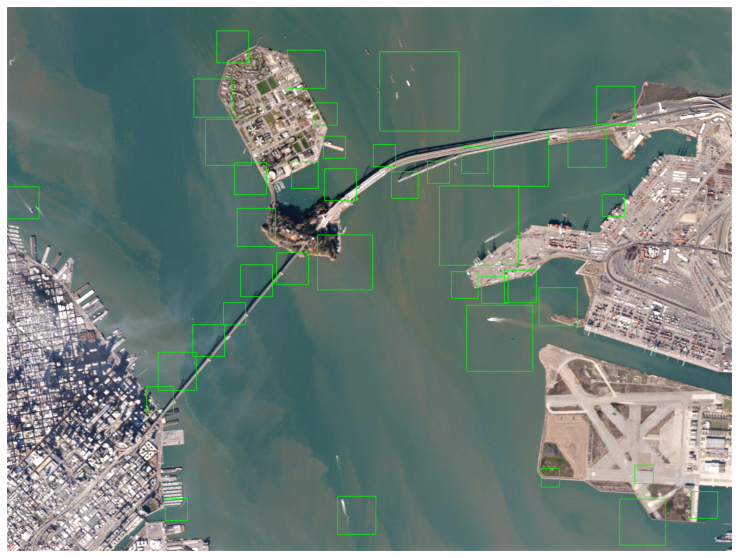

In [13]:
# Show image using matplotlib
plt.rcParams['figure.figsize'] = [20,10]
plt.axis('off')
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
# POST-PROCESSING METHOD USING HSV-BASED THRESHOLDING

i = 0  # patch w/ vessel counter
j = 0  # patch w/o vessel counter

# Threshold 
## Big swath (smaller ships)- 0.05-0.07
## Small swath (bigger ships)- 0.09-0.15
thresh_up = 0.03
thresh_down = 0.0001

for (xA, yA, xB, yB) in pick:
    patch_col = img_orig_clone[yA:yB, xA:xB] # rgb colored patch
    patch_col = cv2.resize(patch_col,(80,80)) # resize the patch for uniformity
    patch_hsv= rgb2hsv(patch_col) # hsv patch
    hue = patch_hsv[:,:,0] #hue 
    sat = patch_hsv[:,:,1] #saturation
    val = patch_hsv[:,:,2] #value
    ##### FIRST SCREEN #####
    if 0.30 > sat.mean() > 0.25: # If normal saturation (medium saturation 1 range)
        x = 1 # use saturation to mask
        low = 0 #red
        up = 0.15 #orange
        m = 0
    else:
        if hue.mean() < 0.20: # If low hue
            x = 0 # use hue to mask
            low = 0.3 #green
            up = 0.7 #dark blue
            m = 1
        elif hue.mean() > 0.40: # If high hue
            x = 0 # use hue to mask
            low = 0.53 #blue
            up = 0.7 #dark blue
            m = 2
        else: # If normal hue
            x = 0 # use hue to mask
            low = 0.45 #sky blue
            up = 0.7 #dark blue
            m = 3
    np.clip(patch_hsv[:,:,x], 0, 1) # normalize color range
    # Masking process
    lower_mask = patch_hsv[:,:,x] > low
    upper_mask = patch_hsv[:,:,x] < up
    mask0 = upper_mask*lower_mask # Initial mask
    ##### SECOND SCREEN #####
    if mask0.mean() == 0: # check in initial mask is = to 0 (all black)
        x = 2 # use value to mask
        if 0.35 > val.mean() >= 0.25:
            low = 0.5 #sky blue
            up = 1 #red
            m = 4
        elif 0.50 > val.mean() >= 0.35:
            low = 0.6 #blue
            up = 1 #red
            m = 5
    np.clip(patch_hsv[:,:,x], 0, 1) # normalize color range
    # Masking process
    lower_mask = patch_hsv[:,:,x] > low
    upper_mask = patch_hsv[:,:,x] < up
    mask = upper_mask*lower_mask # Final mask    
    mask=np.float32(mask) # convertion to 32bit
    ##### DECIDE #####
    if  thresh_down < mask.mean() < thresh_up: # If average pixel value of mask is within the range 
        print('method:', m) # print method number
        print('true:', mask.mean()) # print average pixel value of mask
        cv2.imshow('patch',patch_col) # show patch (must have vessel inside)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        #cv2.imwrite('test.png',patch_col)
        cv2.rectangle(img_orig_clone, (xA, yA), (xB, yB), (0,0,255), 2) # draw red box 
        i = i+1 # patch w/ vessel counter
    else: # If not within the range, patch (ROI) probably does not contain a vessel
        print('method:', m) # print method number
        print('false:', mask.mean()) # print average pixel value of mask
        j= j+1 # patch w/o vessel counter
print('total number of predicted true:',i)
print('total number of predicted false:',j)

method: 3
false: 0.1725
method: 3
false: 0.1125
method: 3
true: 0.026875
method: 3
false: 0.23671874
method: 1
true: 0.02875
method: 1
false: 0.04765625
method: 3
false: 0.16234376
method: 0
false: 0.06125
method: 1
true: 0.0278125
method: 3
false: 0.11546875
method: 3
false: 0.16390625
method: 3
false: 0.17875
method: 3
false: 0.12796874
method: 3
true: 0.008125
method: 3
false: 0.05296875
method: 3
false: 0.26328126
method: 3
false: 0.18953125
method: 0
false: 0.121875
method: 3
false: 0.16734375
method: 1
false: 0.03640625
method: 0
false: 0.15359375
method: 0
false: 0.09765625
method: 3
false: 0.28328124
method: 3
false: 0.0753125
method: 3
true: 0.0078125
method: 3
false: 0.219375
method: 1
true: 0.0259375
method: 3
false: 0.11453125
method: 3
false: 0.12046875
method: 0
false: 0.16484375
method: 3
false: 0.11625
method: 2
false: 0.99609375
method: 3
false: 0.2228125
method: 0
false: 0.16171876
method: 2
false: 0.3715625
method: 3
false: 0.2196875
method: 3
false: 0.265
method: 3


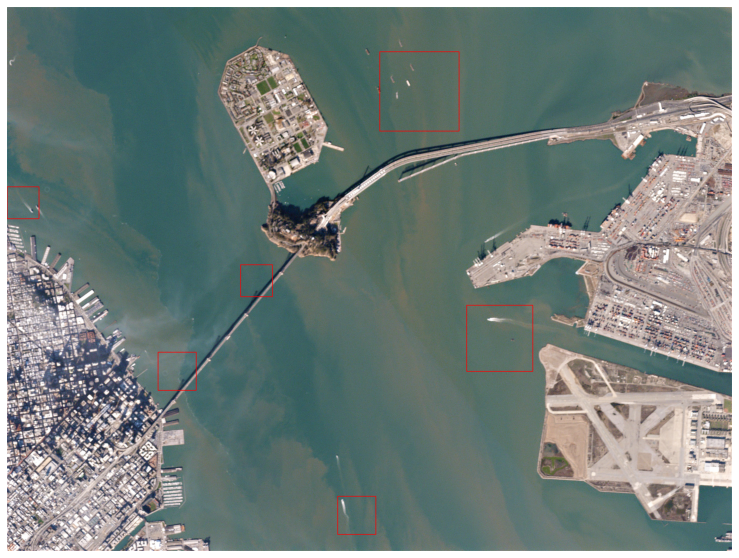

In [15]:
# Show image using matplotlib
plt.rcParams['figure.figsize'] = [20,10]
plt.axis('off')
plt.imshow(cv2.cvtColor(img_orig_clone, cv2.COLOR_BGR2RGB))
plt.show()

#### METHOD INFORMATION:

I. <b>Saturation:</b> <br>
a. Low Sat (< 0.25) 
- orange to yellow background 
- red to dark orange mask (0-0.05)
- small range for mask

b. Medium 1 Sat (0.25-0.30)
- yellow to green background 
- red to orange mask (0-0.15)
- just right

c. Medium 2 Sat (0.30-0.45)
- green to sky blue background 
- red to yellow mask (0-0.2)
- noisy/not coherent

d. High Sat (0.45-0.60)
- sky blue to dark blue background 
- red to green mask (0-0.35)
- noisy/not coherent

e. Extremely High Sat (> 0.60)
- dark blue to red background 
- red to sky blue mask (0-0.5)
- overlapping red, since red is both 0 and 1

II. <b>Hue:</b> <br>
a. Low Hue (< 0.20) 
- red to orange background
- green to dark blue mask (0.3-0.7)

b. Middle Range Hue (0.20-0.40)
- yellow to green background
- sky blue to dark blue mask (0.45-0.7)

c. High Hue (> 0.40)
- green to sky blue background
- blue to dark blue mask (0.53-0.7)

III. <b>Value:</b> <br>
a. Low Value (0.25-0.34) 
- yellow to green background
- sky blue to red mask (0.5-1.0)

b. High Value (0.35-0.50)
- sky blue to green background
- blue to red mask (0.6-1.0)